# Experimentation notebook

In [2]:
import sys
sys.path.append('src/fast_ica')

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from src.iVAE.data import SyntheticDataset, generate_data
from src.iVAE.metrics import mean_corr_coef as mcc
from src.fast_ica import Fast_ICA

%load_ext autoreload
%autoreload 2

## Data generation

### Parameters

In [82]:
number_of_points_by_segment = 1000
number_of_segments = 5
dimension_of_latent_space = 2
dimension_of_data_space = 2
seed = 1
prior = 'gauss'

simple_mixing = True 
linear_transformation_type="uniform"
activation = 'xtanh' # if simple_mixing is True, activation is not used
slope = 0.1 # if simple_mixing is True, slope is not used
number_of_mixing_layers = 3 # if simple_mixing is True, number_of_mixing_layers is not used
repeat_linearity = False # if simple_mixing is True, repeat_linearity is not used

uncentered = True
centers = None# if uncentered is True, centers is not used

var_bounds = np.array([0.5, 3])

noisy = 0
staircase = False

### Generation

In [83]:
source, mixture, segment_labels, mean, variance, mixing_matrix = generate_data(
    n_per_seg=number_of_points_by_segment,
    n_seg=number_of_segments,
    d_sources=dimension_of_latent_space,
    d_data=dimension_of_data_space,
    n_layers=number_of_mixing_layers,
    prior=prior,
    activation=activation,
    seed=seed,
    slope=slope,
    var_bounds=var_bounds,
    lin_type=linear_transformation_type,
    repeat_linearity=repeat_linearity,
    noisy=noisy,
    uncentered=uncentered,
    centers=centers,
    staircase=staircase,
    simple_mixing=simple_mixing,
)
indices = np.argmax(segment_labels, axis=1)


In [84]:
df = pd.concat([
    pd.DataFrame(source, columns=[f"s_{i}" for i in range(source.shape[1])]),
    pd.DataFrame(mixture, columns=[f"x_{i}" for i in range(mixture.shape[1])]),
    pd.DataFrame(indices, columns=["segment"])
], axis=1)

### Visualization

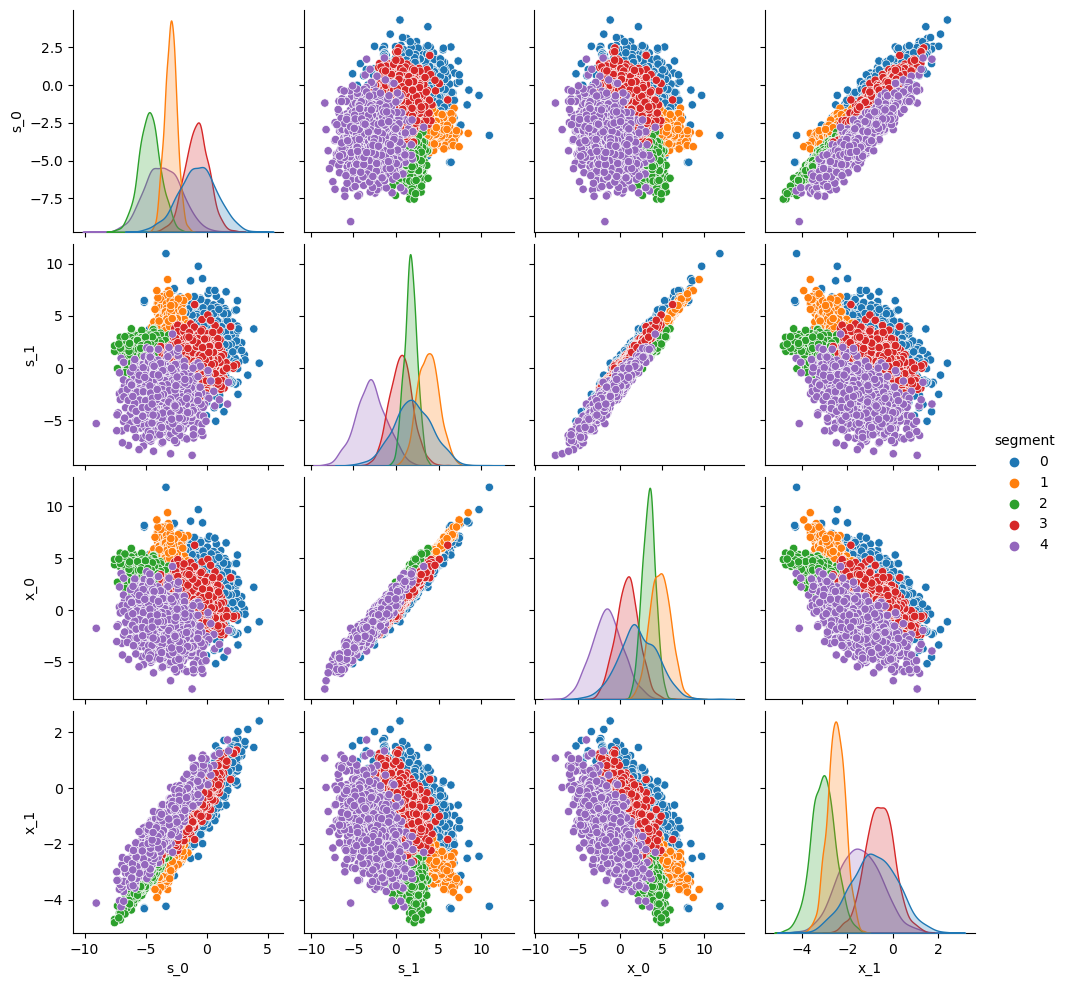

In [85]:
sns.pairplot(df, hue="segment", palette=f"tab10")

Text(0.5, 1.0, 'Original sources')

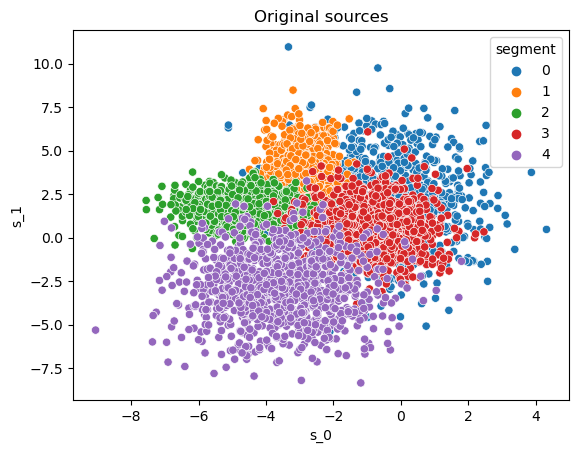

In [86]:
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10")
plt.title("Original sources")

Text(0.5, 1.0, 'Mixed sources')

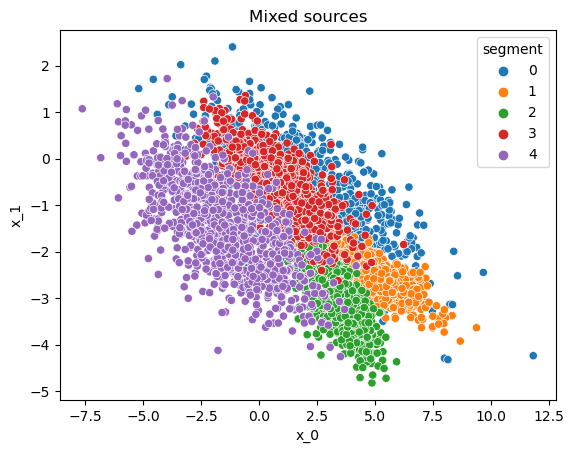

In [87]:
sns.scatterplot(data=df, x="x_0", y="x_1", hue="segment", palette="tab10")
plt.title("Mixed sources")

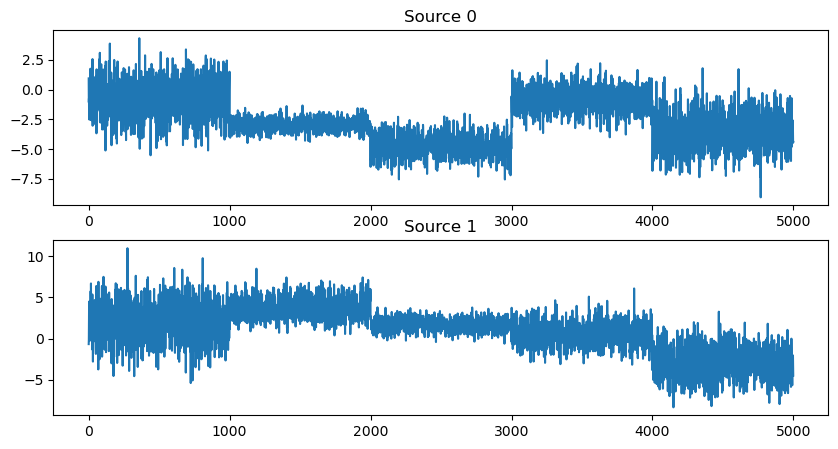

In [88]:
# plot signals
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    axs[i].plot(source[:, i])
    axs[i].set_title(f"Source {i}")

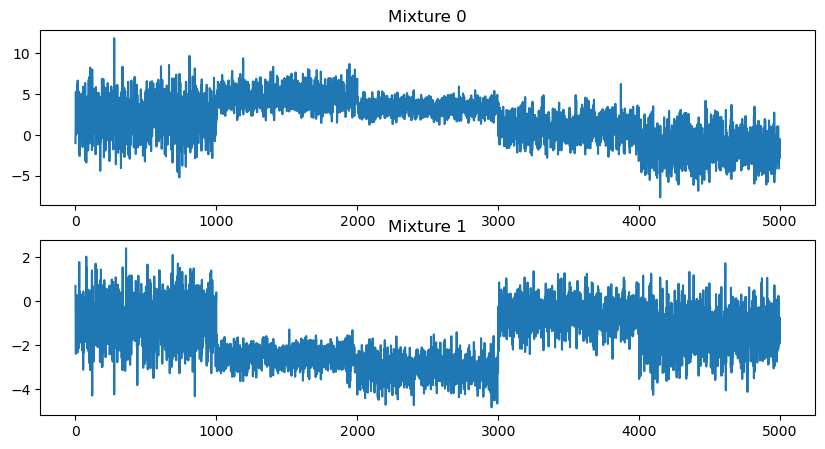

In [89]:
fig, axs = plt.subplots(mixture.shape[1], 1, figsize=(10, 5))
for i in range(mixture.shape[1]):
    axs[i].plot(mixture[:, i])
    axs[i].set_title(f"Mixture {i}")

## FastICA

In [90]:
ica = Fast_ICA(n_components=dimension_of_latent_space, tol=1e-4)
fast_ica_source_predict = ica.fit_transform(mixture.T, method='parallel').T
fast_ica_source_predict

array([[-1.37617962,  1.40947936],
       [-0.52000724,  0.75329264],
       [-1.15247023, -0.30524474],
       ...,
       [ 1.12168681,  0.6764314 ],
       [ 1.51200556,  1.04733911],
       [ 1.62771957,  1.4238043 ]])

In [91]:
df_fast_ica = pd.concat([
  df,
  pd.DataFrame(fast_ica_source_predict, columns=[f"fast_ica_s_{i}" for i in range(fast_ica_source_predict.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'Original sources')

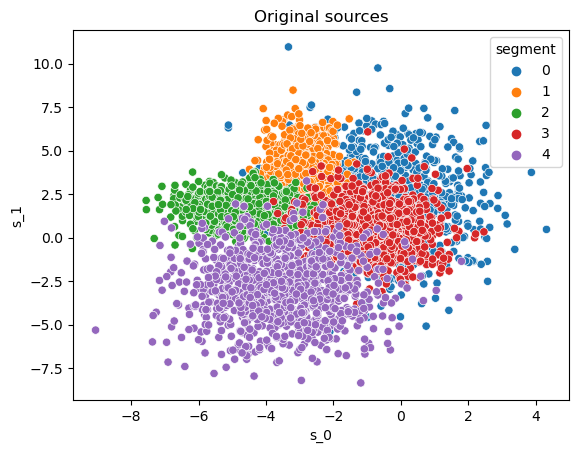

In [95]:
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10")
plt.title("Original sources")

Text(0.5, 1.0, 'Fast ICA recovered sources')

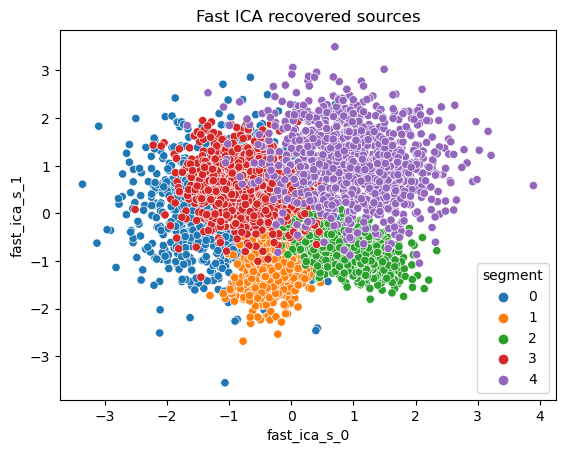

In [92]:
sns.scatterplot(data=df_fast_ica, x="fast_ica_s_0", y="fast_ica_s_1", hue="segment", palette="tab10")
plt.title("Fast ICA recovered sources")

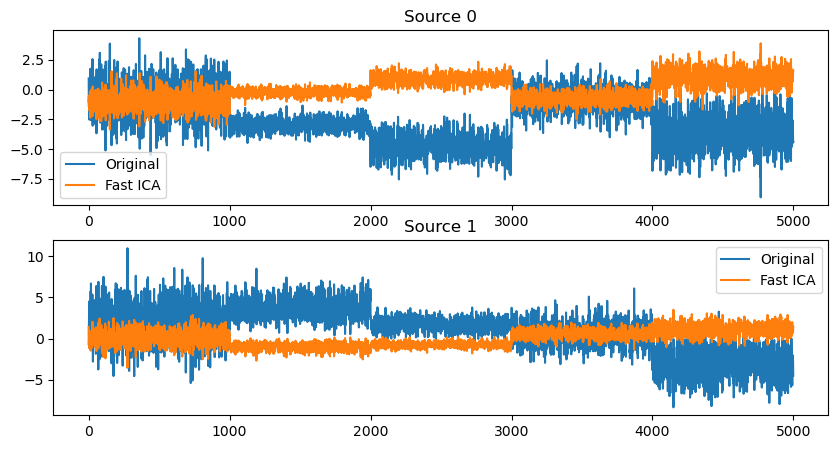

In [96]:
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    axs[i].plot(source[:, i], label="Original")
    axs[i].plot(fast_ica_source_predict[:, i], label="Fast ICA")
    axs[i].set_title(f"Source {i}")
    axs[i].legend()

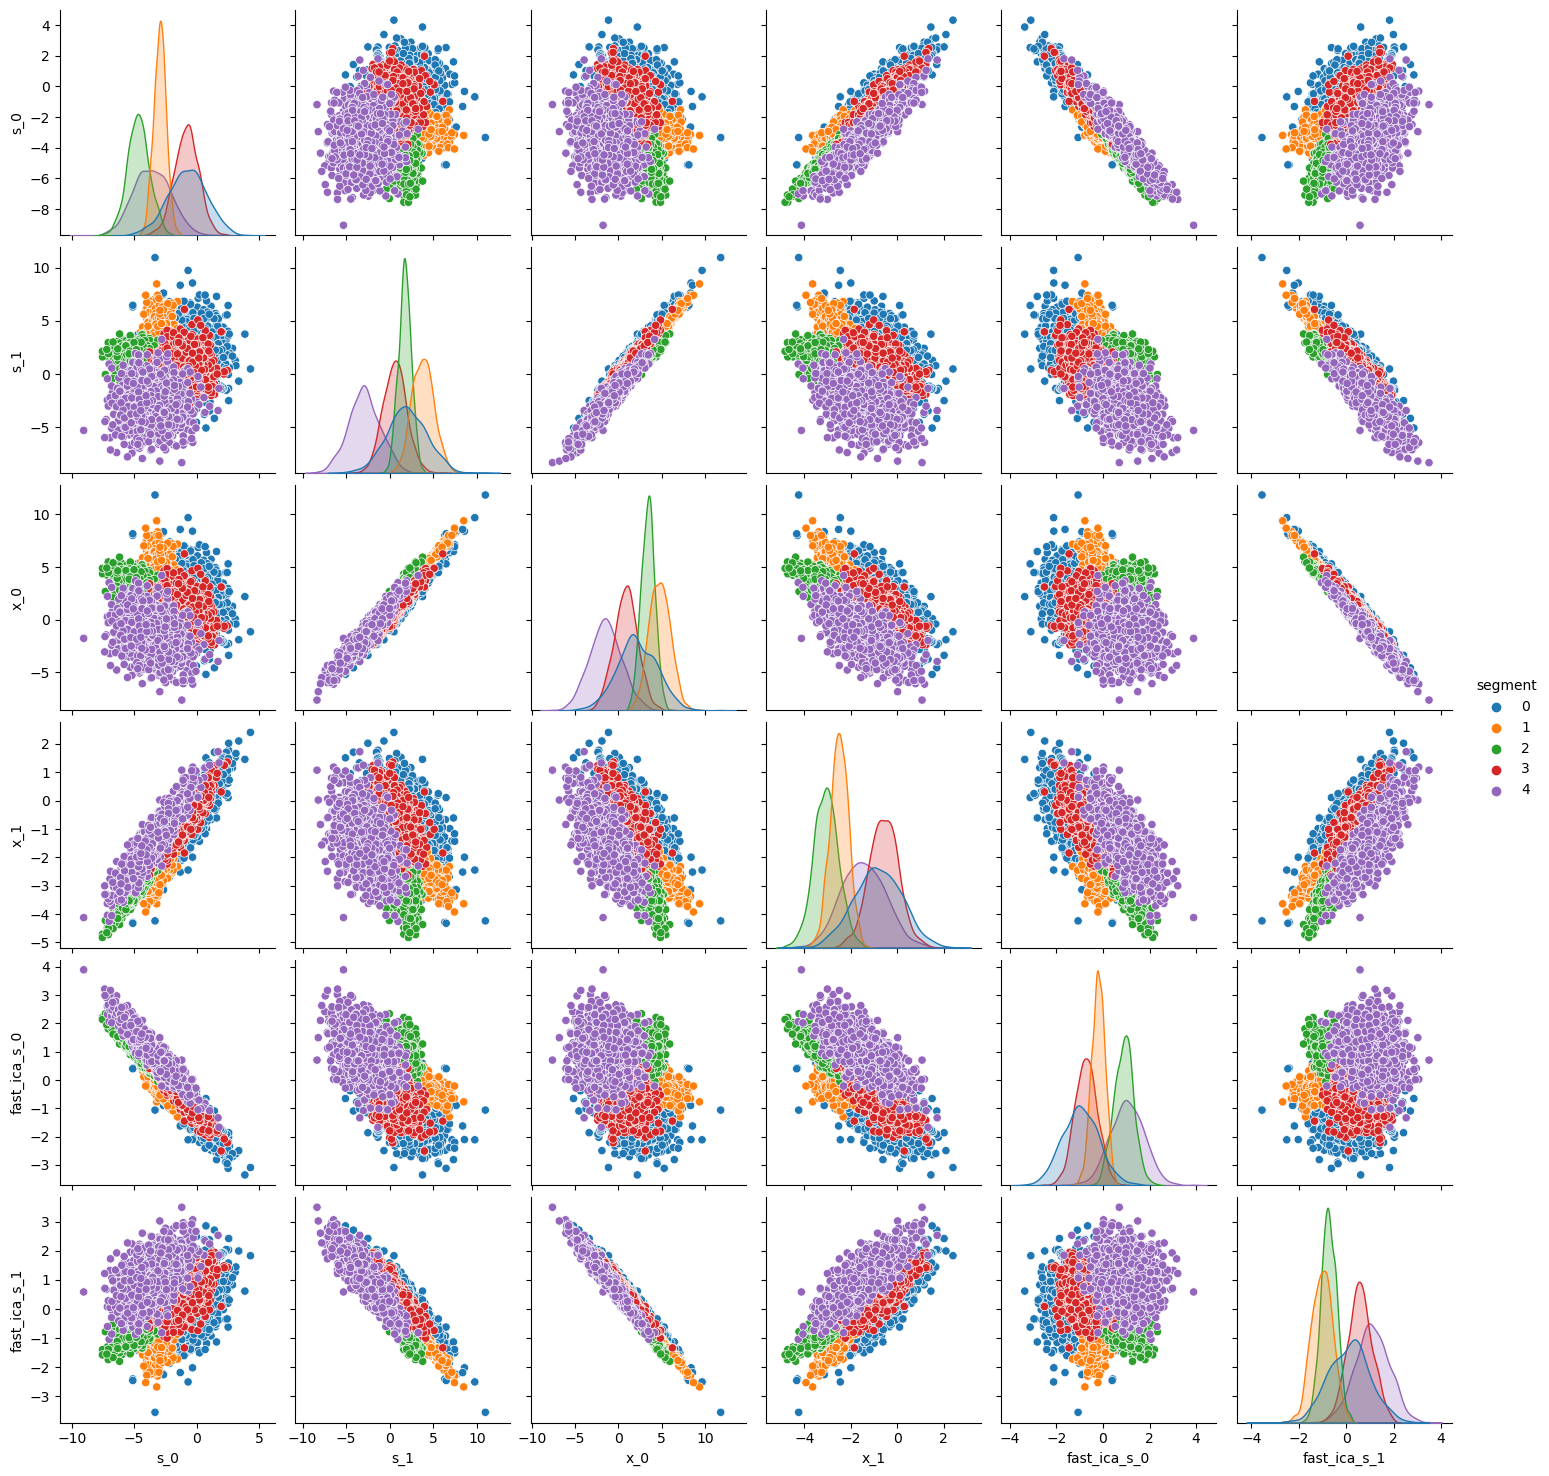

In [94]:
sns.pairplot(df_fast_ica, hue="segment", palette=f"tab10")

In [97]:
mcc(source, fast_ica_source_predict)

0.9043161508256969